# PPO Trading Agent

This notebook trains a **Proximal Policy Optimization (PPO)** agent to trade stocks using reinforcement learning.

## Trading Approach: Close-to-Open

We use a **close-to-open** strategy:

| Time | Action |
|------|--------|
| **Day T close** | Agent observes all Day T data (OHLCV, indicators) |
| **Day T close** | Agent decides position for overnight |
| **Day T+1 open** | Trade executes at next day's open price |

**Why this works without shifting features:**
- At market close, all of Day T's data is known (Open, High, Low, Close, Volume)
- Decision is made after close, so no lookahead bias
- Position is held overnight, captured in next day's open-to-close move

This is realistic for:
- EOD (end-of-day) trading systems
- Swing trading strategies
- Any strategy that doesn't require intraday execution

---

## Workflow
1. **Data & Diagnostics** - Load features and check predictiveness
2. **Environment Setup** - Configure trading simulation with reward shaping
3. **Training** - Train PPO with tuned hyperparameters
4. **Evaluation** - Test on held-out data with comprehensive metrics
5. **Feature Selection** - Ablation study to find best features

---

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

import sys
sys.path.append("/Users/pnl1f276/code/bennystu/trend_surgeon/Trend-Surgeon-Time-Series/ts_boilerplate")

from gym_anytrading.envs.flexible_env import FlexibleTradingEnv
from dataprep import build_feature_dataset, get_X_y

## 2. Load Data

Build the feature dataset. All features use **no shifting** since we're using a close-to-open approach where decisions are made after market close with full knowledge of the day's data.

In [2]:
df = build_feature_dataset()

--- Data Integrity Report ---
Rows: 2,891, Columns: 33
Index sorted: True
Index unique: True
Rows that are entirely NaN: 0
Inf values: 0

Top columns with NaNs:
  (None)

--- Data Integrity Report ---
Rows: 2,891, Columns: 33
Index sorted: True
Index unique: True
Rows that are entirely NaN: 0
Inf values: 0

Top columns with NaNs:
  (None)

Markdown feature documentation written to: ../docs/feature_documentation.md


## 3. Feature Predictiveness Diagnostic

**Run this first!** Tests if today's features can predict tomorrow's price direction.

- If test accuracy ≈ 50%, features have no predictive power → RL won't work
- Look at feature importances to identify what matters

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Prepare data
feature_cols = df.columns.drop("target_close")
X = df[feature_cols].values
prices_arr = df["target_close"].values

# Target: next day direction (1 = up, 0 = down)
y = (prices_arr[1:] > prices_arr[:-1]).astype(int)
X = X[:-1]

# Train/test split (temporal)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test multiple models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

print(f"Predicting next-day direction (Up/Down)")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Base rate: Train={y_train.mean()*100:.1f}% up, Test={y_test.mean()*100:.1f}% up\n")
print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'Test AUC':<12} {'Verdict'}")
print("-"*70)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    try:
        test_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    except:
        test_auc = 0.5

    verdict = "Promising" if test_acc > 0.55 and test_auc > 0.55 else "Weak signal" if test_acc > 0.52 else "No signal"
    print(f"{name:<25} {train_acc*100:>6.1f}%     {test_acc*100:>6.1f}%     {test_auc:>6.3f}       {verdict}")

# Feature importance
rf_model = models["Random Forest"]
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTOP 10 FEATURES:")
for i, row in importances.head(10).iterrows():
    bar = '█' * int(row['importance'] * 100)
    print(f"  {row['feature']:<30} {row['importance']:.4f} {bar}")

feature_importances = importances

Predicting next-day direction (Up/Down)
Train: 2312, Test: 578
Base rate: Train=51.2% up, Test=52.2% up

Model                     Train Acc    Test Acc     Test AUC     Verdict
----------------------------------------------------------------------
Logistic Regression         54.8%       49.8%      0.501       No signal
Random Forest               73.0%       51.9%      0.541       No signal
Random Forest               73.0%       51.9%      0.541       No signal
Gradient Boosting           79.8%       51.7%      0.533       No signal

TOP 10 FEATURES:
  XPH_Return_1d                  0.0623 ██████
  XPH_Close                      0.0455 ████
  PPH_Return_1d                  0.0433 ████
  XPH_Ratio_PPH                  0.0431 ████
  XPH_Volume                     0.0406 ████
  days_to_cpi                    0.0401 ████
  days_since_nfp                 0.0391 ███
  PPH_Entropy_20                 0.0390 ███
  PPH_High                       0.0384 ███
  PPH_SMA_10                     0.03

## 4. Prepare Features & Prices

Extract the target price series and feature matrix for the trading environment.

In [4]:
prices = df["target_close"].values.astype(np.float32)

# Remove macro features
keywords = ["cpi", "nfp", "holiday"]
cols_to_drop = df.columns[df.columns.str.contains("|".join(keywords), case=False)]
df = df.drop(columns=cols_to_drop)

# Remove target feature (keep column names, not a DataFrame)
feature_cols = df.columns.drop("target_close")



signal_features = df[feature_cols].values.astype(np.float32)

## 5. Train/Test Split

Split data temporally (80/20) to evaluate on unseen future data.

In [5]:
window_size = 30
train_ratio = 0.8

total_len = len(df)
train_end = int(total_len * train_ratio)

train_frame_bound = (window_size, train_end)
test_frame_bound = (train_end, total_len)

print(f"Total samples: {total_len}")
print(f"Train: {train_frame_bound} ({train_end - window_size} steps)")
print(f"Test:  {test_frame_bound} ({total_len - train_end} steps)")

Total samples: 2891
Train: (30, 2312) (2282 steps)
Test:  (2312, 2891) (579 steps)


## 6. Environment Configuration

Configure the `FlexibleTradingEnv` with reward shaping parameters:

| Parameter | Description |
|-----------|-------------|
| `reward_scaling` | Multiplies small log-returns for stronger signal |
| `trade_penalty` | Extra cost per trade to reduce churning |
| `profit_bonus` | Bonus multiplier for profitable positions |
| `trend_following_bonus` | Small reward for aligning with trend |

In [6]:
REWARD_CONFIG = {
    'fee': 0.0005,              # 0.05% per trade
    'holding_cost': 0.0,
    'short_borrow_cost': 0.0,
    # Additional shaping parameters (not supported by the env constructor),
    # will be applied to the env instance only if the attribute exists.
    'reward_scaling': 100.0,    # Scale up tiny log-returns
    'trade_penalty': 0.001,     # Reduce churning
    'profit_bonus': 0.5,        # 50% bonus on profits
    'trend_following_bonus': 0.0001,
}

print("Reward Config:", REWARD_CONFIG)

def make_train_env():
    def _init():
        # Pass only supported constructor args; do not expand REWARD_CONFIG directly
        env = FlexibleTradingEnv(
            df=df, prices=prices, signal_features=signal_features,
            window_size=window_size, frame_bound=train_frame_bound,
            include_position_in_obs=True,
            fee=REWARD_CONFIG.get('fee', 0.0005),
            holding_cost=REWARD_CONFIG.get('holding_cost', 0.0),
            short_borrow_cost=REWARD_CONFIG.get('short_borrow_cost', 0.0),
        )
        # Apply extra shaping attributes only if the env supports them
        for k, v in REWARD_CONFIG.items():
            if hasattr(env, k):
                setattr(env, k, v)
        return env
    return _init

def make_test_env():
    def _init():
        env = FlexibleTradingEnv(
            df=df, prices=prices, signal_features=signal_features,
            window_size=window_size, frame_bound=test_frame_bound,
            include_position_in_obs=True,
            fee=REWARD_CONFIG.get('fee', 0.0005),
            holding_cost=REWARD_CONFIG.get('holding_cost', 0.0),
            short_borrow_cost=REWARD_CONFIG.get('short_borrow_cost', 0.0),
        )
        for k, v in REWARD_CONFIG.items():
            if hasattr(env, k):
                setattr(env, k, v)
        return env
    return _init

Reward Config: {'fee': 0.0005, 'holding_cost': 0.0, 'short_borrow_cost': 0.0, 'reward_scaling': 100.0, 'trade_penalty': 0.001, 'profit_bonus': 0.5, 'trend_following_bonus': 0.0001}


## 7. Create Vectorized Environments

Wrap environments with `VecNormalize` for observation and reward normalization.

In [7]:
train_env = DummyVecEnv([make_train_env()])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_reward=np.inf)

# Use a separate env for evaluation (do NOT reuse training env factory)
eval_callback_env = DummyVecEnv([make_test_env()])
eval_callback_env = VecNormalize(eval_callback_env, training=False, norm_obs=True, norm_reward=False)

## 8. PPO Model

Key hyperparameters tuned for trading:

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| `n_steps` | 2048 | Longer rollouts capture multi-day patterns |
| `ent_coef` | 0.05 | Higher exploration (default 0.01) |
| `gamma` | 0.95 | Shorter horizon focus for trading |
| `net_arch` | [256, 256] | Wider networks for complex patterns |

In [8]:
model = PPO(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=lambda progress: 3e-4 * (1 - progress * 0.5),
    n_steps=2048,
    batch_size=64,
    gamma=0.95,
    gae_lambda=0.9,
    ent_coef=0.05,
    clip_range=0.2,
    n_epochs=10,
    vf_coef=0.5,
    max_grad_norm=0.5,
    normalize_advantage=True,
    policy_kwargs=dict(net_arch=dict(pi=[256, 256], vf=[256, 256])),
    verbose=1,
    tensorboard_log="./ppo_logs/",
    seed=42
)

Using cpu device


## 9. Training Callbacks

- `SyncNormCallback`: Syncs normalization stats between train and eval envs
- `EvalCallback`: Periodic evaluation and saves best model
- `CheckpointCallback`: Saves model checkpoints

In [9]:
from stable_baselines3.common.callbacks import BaseCallback

class SyncNormCallback(BaseCallback):
    """Syncs VecNormalize stats from train_env to eval_env."""
    def __init__(self, train_env, eval_env, verbose=0):
        super().__init__(verbose)
        self.train_env = train_env
        self.eval_env = eval_env

    def _on_step(self):
        self.eval_env.obs_rms = self.train_env.obs_rms
        self.eval_env.ret_rms = self.train_env.ret_rms
        return True

sync_callback = SyncNormCallback(train_env, eval_callback_env)

eval_callback = EvalCallback(
    eval_callback_env,
    best_model_save_path="./ppo_best_model/",
    log_path="./ppo_eval_logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path="./ppo_checkpoints/",
    name_prefix="ppo_trading_model"
)

## 10. Train the Model

Training for **50k timesteps** (~2-3 min on M4 Mac). Increase to 200k for better results when ready.

In [10]:
model.learn(
    total_timesteps=200_000,
    callback=[sync_callback, eval_callback, checkpoint_callback]
)

model.save("ppo_trading_final")
train_env.save("vec_normalize.pkl")
print("Model saved!")

Logging to ./ppo_logs/PPO_19
-----------------------------
| time/              |      |
|    fps             | 5405 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3088        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015789105 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.613      |
|    learning_rate        | 0.000152    |
|    loss                 | -0.0873     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0339     |
|    value_loss           | 0.0805      |
-----------------------------------------
Eval 

## 11. Sanity Check (Train Data)

Quick check that the model learned something on training data.

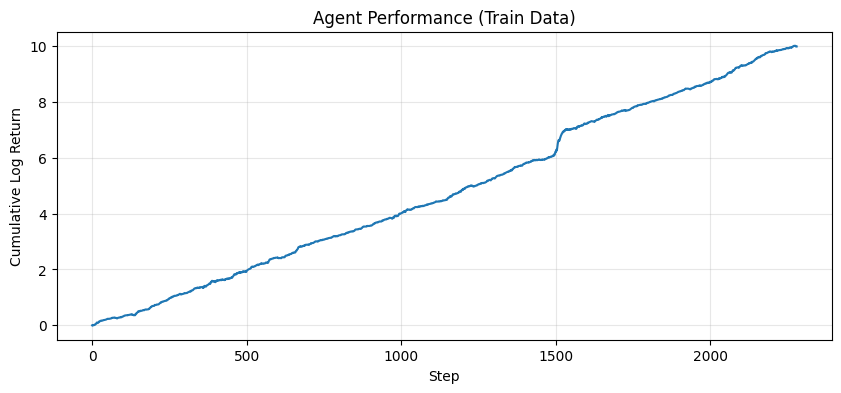

In [11]:
sanity_env = DummyVecEnv([make_train_env()])
sanity_env = VecNormalize.load("vec_normalize.pkl", sanity_env)
sanity_env.training = False
sanity_env.norm_reward = False

model = PPO.load("ppo_trading_final")

obs = sanity_env.reset()
done = False
profits = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = sanity_env.step(action)
    profits.append(info[0]["total_profit"])

plt.figure(figsize=(10, 4))
plt.plot(profits)
plt.title("Agent Performance (Train Data)")
plt.xlabel("Step")
plt.ylabel("Cumulative Log Return")
plt.grid(alpha=0.3)
plt.show()

## 12. Evaluation Function

Comprehensive evaluation with:
- **Equity curves** (net & gross) vs Buy & Hold
- **Risk metrics**: Sharpe, Max Drawdown, Calmar
- **Trade analysis**: Win rate, profit factor
- **Visualizations**: Drawdown chart, position map, trade distribution

In [12]:
def evaluate_agent(model, vec_env, episodes=1, fee=0.0005):
    """
    Comprehensive evaluation for a trading env using SB3 + VecNormalize.

    Includes:
    - Equity curve with transaction costs
    - Multiple benchmarks (Buy & Hold, Short & Hold)
    - Detailed performance metrics
    - Position analysis
    - Drawdown visualization
    - Trade markers
    """

    # Get raw (true) underlying environment
    base_env = vec_env.venv.envs[0].unwrapped
    all_prices = base_env.prices.astype(float)
    start_tick = base_env._start_tick

    print("\n" + "="*60)
    print("EVALUATION STARTED")
    print("="*60)
    print(f"Environment starts at tick {start_tick}")

    for ep in range(episodes):

        obs = vec_env.reset()
        done = False

        # Track equity and positions indexed by tick for proper alignment
        equity_by_tick = {}      # tick -> equity value (net)
        equity_gross_by_tick = {}  # tick -> equity value (gross)
        positions_by_tick = {}   # tick -> position

        positions = []
        ticks = []
        actions_taken = []

        # Start portfolio at 1.0
        current_equity_gross = 1.0
        current_equity_net = 1.0
        last_position = 0

        # Get initial tick after reset
        current_tick = base_env._current_tick
        ticks.append(current_tick)
        equity_by_tick[current_tick] = current_equity_net
        equity_gross_by_tick[current_tick] = current_equity_gross
        positions_by_tick[current_tick] = 0
        positions.append(0)

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = vec_env.step(action)

            done = bool(done[0])
            info = info[0]

            current_tick = info["tick"]
            pos = info["position"]

            ticks.append(current_tick)
            positions.append(pos)
            positions_by_tick[current_tick] = pos
            actions_taken.append(int(action[0]) if hasattr(action, '__len__') else int(action))

            # Update equity using actual price indices
            if len(ticks) > 1:
                prev_tick = ticks[-2]
                price_ratio = all_prices[current_tick] / all_prices[prev_tick]

                # Gross equity (no fees)
                current_equity_gross *= price_ratio ** last_position

                # Net equity (with fees)
                current_equity_net *= price_ratio ** last_position
                if pos != last_position:
                    if last_position == 0:
                        current_equity_net *= (1 - fee)
                    elif pos == 0:
                        current_equity_net *= (1 - fee)
                    else:  # flip
                        current_equity_net *= (1 - 2*fee)

            equity_by_tick[current_tick] = current_equity_net
            equity_gross_by_tick[current_tick] = current_equity_gross
            last_position = pos

        # ============================================
        # BENCHMARKS - aligned by tick
        # ============================================
        first_tick = ticks[0]
        last_tick = ticks[-1]

        # Create aligned arrays using actual ticks
        aligned_ticks = sorted(equity_by_tick.keys())
        equity_net = [equity_by_tick[t] for t in aligned_ticks]
        equity_gross = [equity_gross_by_tick[t] for t in aligned_ticks]

        # Buy & Hold: computed at each tick visited
        first_price = all_prices[first_tick]
        buy_hold = [all_prices[t] / first_price for t in aligned_ticks]
        short_hold = [first_price / all_prices[t] for t in aligned_ticks]

        # Price segment at each tick
        price_segment = [all_prices[t] for t in aligned_ticks]

        # ============================================
        # TRADE ANALYSIS
        # ============================================
        positions_arr = np.array(positions)
        position_changes = np.diff(positions_arr)
        trade_indices = np.where(position_changes != 0)[0] + 1

        # Calculate per-trade returns
        trade_returns = []
        if len(trade_indices) > 1:
            for i in range(len(trade_indices) - 1):
                start_idx = trade_indices[i]
                end_idx = trade_indices[i + 1]
                pos_during = positions_arr[start_idx]

                start_price = all_prices[ticks[start_idx]]
                end_price = all_prices[ticks[end_idx]]

                if pos_during == 1:  # Long
                    ret = (end_price / start_price) - 1
                elif pos_during == -1:  # Short
                    ret = (start_price / end_price) - 1
                else:
                    ret = 0
                trade_returns.append(ret)

        trade_returns = np.array(trade_returns)
        winning_trades = trade_returns[trade_returns > 0]
        losing_trades = trade_returns[trade_returns < 0]

        # ============================================
        # METRICS
        # ============================================
        equity_arr = np.array(equity_net)
        buy_hold_arr = np.array(buy_hold)
        returns = np.diff(np.log(equity_arr + 1e-12))

        # Core metrics
        total_return = (equity_arr[-1] / equity_arr[0]) - 1
        total_return_gross = (equity_gross[-1] / equity_gross[0]) - 1
        bh_return = (buy_hold_arr[-1] / buy_hold_arr[0]) - 1
        sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)

        # Drawdown
        running_max = np.maximum.accumulate(equity_arr)
        drawdowns = (running_max - equity_arr) / running_max
        max_dd = np.max(drawdowns)

        # Calmar ratio
        calmar = (total_return * 252 / len(returns)) / (max_dd + 1e-8) if max_dd > 0 else 0

        # Trade metrics
        n_trades = len(trade_returns)
        win_rate = len(winning_trades) / n_trades * 100 if n_trades > 0 else 0
        avg_win = np.mean(winning_trades) * 100 if len(winning_trades) > 0 else 0
        avg_loss = np.mean(losing_trades) * 100 if len(losing_trades) > 0 else 0
        profit_factor = abs(np.sum(winning_trades) / np.sum(losing_trades)) if len(losing_trades) > 0 and np.sum(losing_trades) != 0 else np.inf

        # Position analysis
        long_pct = np.sum(positions_arr == 1) / len(positions_arr) * 100
        short_pct = np.sum(positions_arr == -1) / len(positions_arr) * 100
        flat_pct = np.sum(positions_arr == 0) / len(positions_arr) * 100

        # ============================================
        # ALIGNMENT CHECK
        # ============================================
        # Count how often PPO beats Buy & Hold
        ppo_vs_bh = equity_arr - buy_hold_arr
        ahead_count = np.sum(ppo_vs_bh > 0)
        behind_count = np.sum(ppo_vs_bh < 0)

        # ============================================
        # PRINT RESULTS
        # ============================================
        print(f"\n{'─'*60}")
        print(f"EPISODE {ep+1} RESULTS")
        print(f"{'─'*60}")

        print(f"\n📊 RETURNS")
        print(f"   Total Return (net):    {total_return*100:+.2f}%")
        print(f"   Total Return (gross):  {total_return_gross*100:+.2f}%")
        print(f"   Buy & Hold Return:     {bh_return*100:+.2f}%")
        print(f"   Short & Hold Return:   {(short_hold[-1]-1)*100:+.2f}%")
        print(f"   Outperformance vs B&H: {(total_return - bh_return)*100:+.2f}%")

        print(f"\n📉 ALIGNMENT CHECK")
        print(f"   Steps where PPO > B&H: {ahead_count} ({100*ahead_count/len(equity_arr):.1f}%)")
        print(f"   Steps where PPO < B&H: {behind_count} ({100*behind_count/len(equity_arr):.1f}%)")

        print(f"\n📈 RISK METRICS")
        print(f"   Sharpe Ratio (ann.):   {sharpe:.3f}")
        print(f"   Max Drawdown:          {max_dd*100:.2f}%")
        print(f"   Calmar Ratio:          {calmar:.3f}")

        print(f"\n🔄 TRADE ANALYSIS")
        print(f"   Total Trades:          {n_trades}")
        print(f"   Win Rate:              {win_rate:.1f}%")
        print(f"   Avg Winning Trade:     {avg_win:+.2f}%")
        print(f"   Avg Losing Trade:      {avg_loss:+.2f}%")
        print(f"   Profit Factor:         {profit_factor:.2f}")

        print(f"\n⚖️  POSITION DISTRIBUTION")
        print(f"   Long:  {long_pct:5.1f}%  {'█' * int(long_pct/5)}")
        print(f"   Short: {short_pct:5.1f}%  {'█' * int(short_pct/5)}")
        print(f"   Flat:  {flat_pct:5.1f}%  {'█' * int(flat_pct/5)}")

        # ============================================
        # PLOT 1: EQUITY CURVES (properly aligned)
        # ============================================
        fig, axes = plt.subplots(3, 1, figsize=(14, 12))

        x_axis = np.arange(len(aligned_ticks))

        # Panel 1: Price + Equity
        ax1 = axes[0]
        ax1_twin = ax1.twinx()

        ax1.plot(x_axis, price_segment, color="blue", alpha=0.4, linewidth=1, label="Price")
        ax1.set_ylabel("Price", color="blue")
        ax1.tick_params(axis="y", labelcolor="blue")

        ax1_twin.plot(x_axis, equity_net, color="green", linewidth=2, label="PPO (net)")
        ax1_twin.plot(x_axis, equity_gross, color="lightgreen", linewidth=1, linestyle="--", label="PPO (gross)", alpha=0.7)
        ax1_twin.plot(x_axis, buy_hold, color="gray", linewidth=1.5, linestyle="--", label="Buy & Hold")
        ax1_twin.plot(x_axis, short_hold, color="red", linewidth=1, linestyle=":", alpha=0.5, label="Short & Hold")
        ax1_twin.axhline(y=1.0, color="black", linestyle="-", alpha=0.3)
        ax1_twin.set_ylabel("Equity", color="green")
        ax1_twin.tick_params(axis="y", labelcolor="green")
        ax1_twin.legend(loc="upper left")

        ax1.set_title("Equity Curves vs Benchmarks (Aligned by Tick)", fontsize=12, fontweight="bold")
        ax1.grid(alpha=0.3)

        # Panel 2: Drawdown
        ax2 = axes[1]
        ax2.fill_between(x_axis, 0, -drawdowns*100, color="red", alpha=0.3)
        ax2.plot(x_axis, -drawdowns*100, color="red", linewidth=1)
        ax2.axhline(y=-max_dd*100, color="darkred", linestyle="--", label=f"Max DD: {max_dd*100:.1f}%")
        ax2.set_ylabel("Drawdown (%)")
        ax2.set_title("Underwater Curve (Drawdown)", fontsize=12, fontweight="bold")
        ax2.legend(loc="lower left")
        ax2.grid(alpha=0.3)

        # Panel 3: Position over time with trade markers
        ax3 = axes[2]

        # Color the background based on position
        for i in range(len(x_axis) - 1):
            if i < len(positions):
                if positions[i] == 1:
                    ax3.axvspan(i, i+1, alpha=0.3, color="green")
                elif positions[i] == -1:
                    ax3.axvspan(i, i+1, alpha=0.3, color="red")

        ax3.plot(x_axis, price_segment, color="blue", linewidth=1, alpha=0.7)

        # Mark trades
        for idx in trade_indices:
            if idx < len(x_axis):
                marker = "^" if positions[idx] == 1 else "v"
                color = "green" if positions[idx] == 1 else "red"
                ax3.scatter(idx, price_segment[idx], marker=marker, color=color, s=50, zorder=5)

        ax3.set_ylabel("Price")
        ax3.set_xlabel("Step")
        ax3.set_title("Position & Trade Markers (▲=Long, ▼=Short)", fontsize=12, fontweight="bold")
        ax3.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # ============================================
        # PLOT 2: TRADE RETURN DISTRIBUTION
        # ============================================
        if len(trade_returns) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram
            ax1 = axes[0]
            ax1.hist(trade_returns * 100, bins=30, color="steelblue", edgecolor="white", alpha=0.7)
            ax1.axvline(x=0, color="black", linestyle="--")
            ax1.axvline(x=np.mean(trade_returns)*100, color="green", linestyle="-", label=f"Mean: {np.mean(trade_returns)*100:.2f}%")
            ax1.set_xlabel("Trade Return (%)")
            ax1.set_ylabel("Frequency")
            ax1.set_title("Trade Return Distribution", fontsize=12, fontweight="bold")
            ax1.legend()
            ax1.grid(alpha=0.3)

            # Cumulative trade returns
            ax2 = axes[1]
            cum_trade_returns = np.cumprod(1 + trade_returns)
            ax2.plot(cum_trade_returns, color="green", linewidth=2)
            ax2.axhline(y=1.0, color="black", linestyle="--", alpha=0.5)
            ax2.set_xlabel("Trade #")
            ax2.set_ylabel("Cumulative Return")
            ax2.set_title("Cumulative Returns by Trade", fontsize=12, fontweight="bold")
            ax2.grid(alpha=0.3)

            plt.tight_layout()
            plt.show()

    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60 + "\n")

    return {
        "total_return": total_return,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "win_rate": win_rate,
        "profit_factor": profit_factor,
        "n_trades": n_trades,
        "equity_curve": equity_net,
        "buy_hold": buy_hold,
        "positions": positions,
        "ticks": aligned_ticks,
        "ppo_ahead_pct": 100*ahead_count/len(equity_arr),
        "ppo_behind_pct": 100*behind_count/len(equity_arr)
    }

## 13. Final Evaluation (Test Data)

**The real test**: Evaluate on held-out data the model has never seen.


EVALUATION STARTED
Environment starts at tick 2312

────────────────────────────────────────────────────────────
EPISODE 1 RESULTS
────────────────────────────────────────────────────────────

📊 RETURNS
   Total Return (net):    +11.83%
   Total Return (gross):  +39.43%
   Buy & Hold Return:     +6.02%
   Short & Hold Return:   -5.68%
   Outperformance vs B&H: +5.81%

📉 ALIGNMENT CHECK
   Steps where PPO > B&H: 105 (18.1%)
   Steps where PPO < B&H: 473 (81.7%)

📈 RISK METRICS
   Sharpe Ratio (ann.):   0.340
   Max Drawdown:          26.25%
   Calmar Ratio:          0.196

🔄 TRADE ANALYSIS
   Total Trades:          220
   Win Rate:              55.5%
   Avg Winning Trade:     +1.11%
   Avg Losing Trade:      -1.04%
   Profit Factor:         1.36

⚖️  POSITION DISTRIBUTION
   Long:   41.5%  ████████
   Short:  58.4%  ███████████
   Flat:    0.2%  


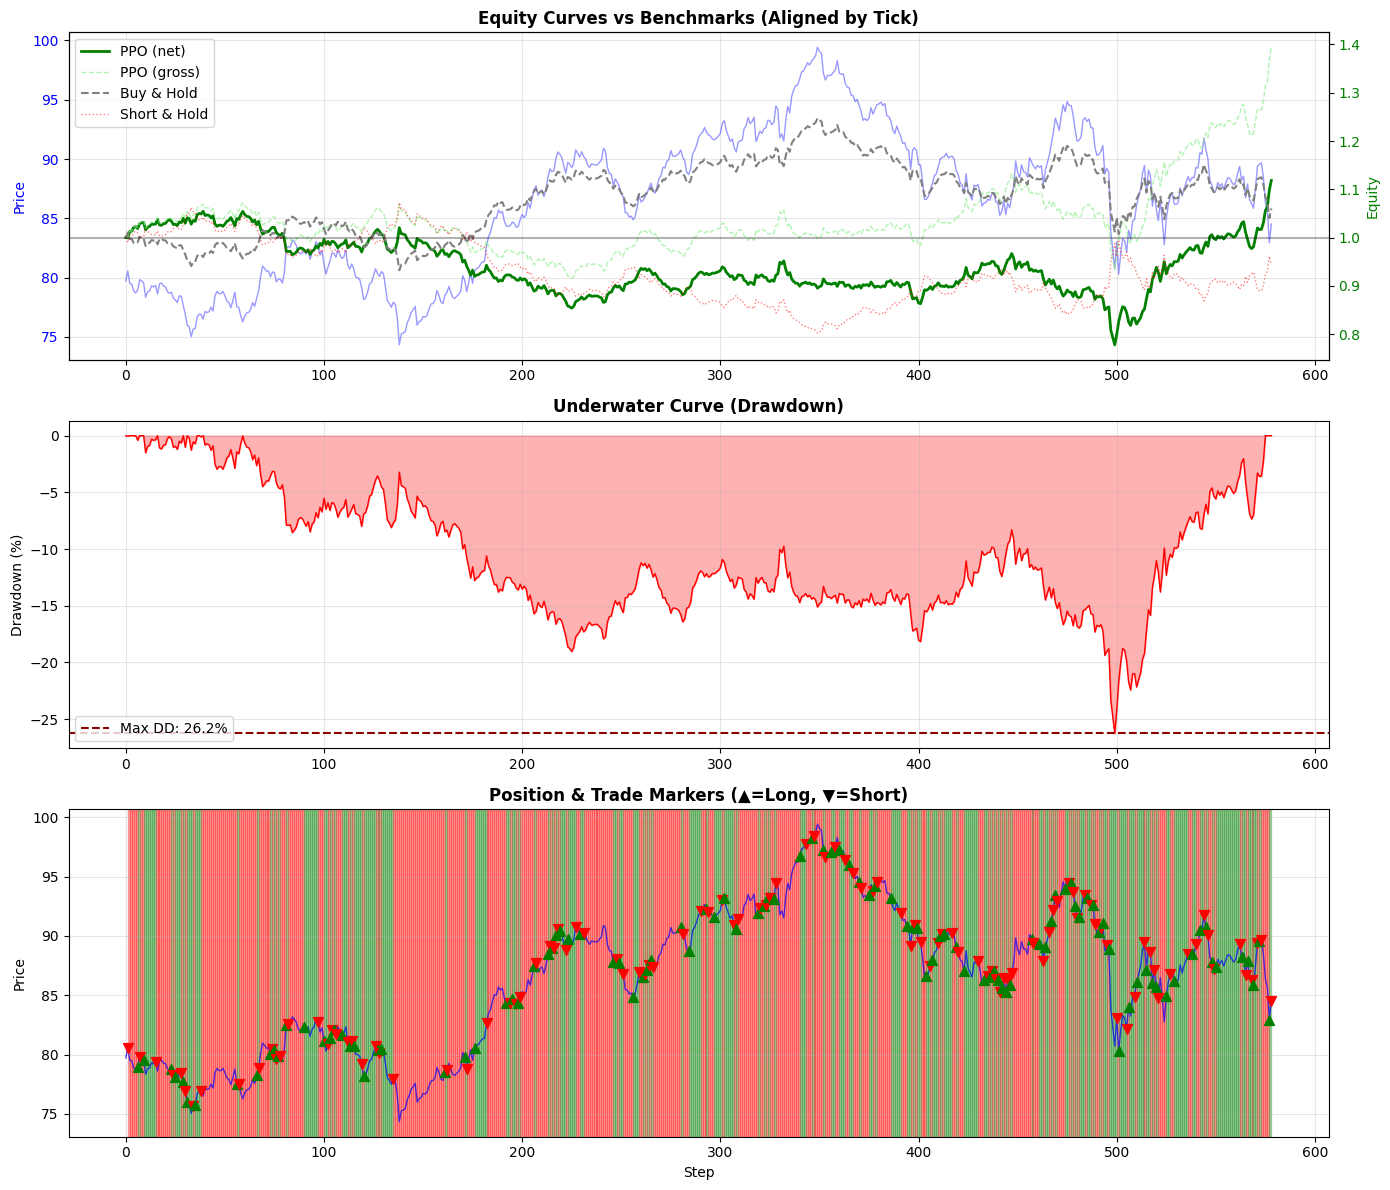

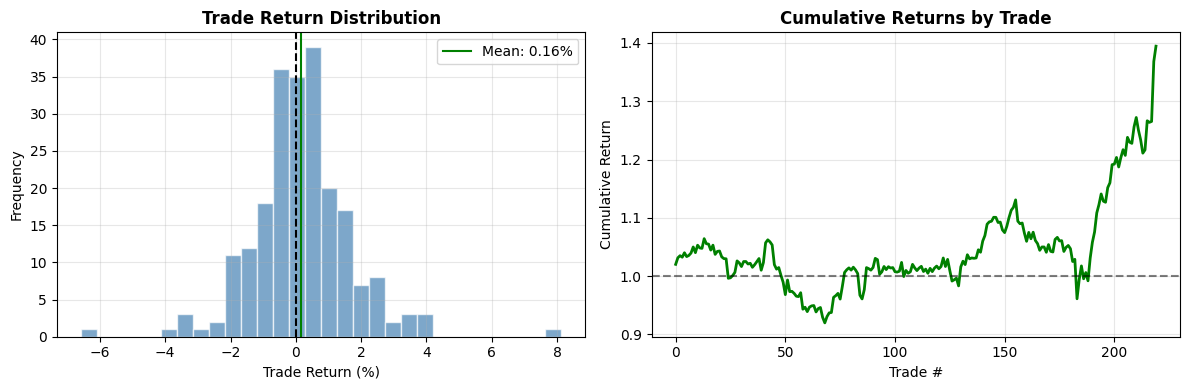


EVALUATION COMPLETE


RETURNED RESULTS SUMMARY
Total Return: +11.83%
Sharpe Ratio: 0.340
Max Drawdown: 26.25%
Win Rate: 55.5%
PPO ahead of B&H: 18.1% of steps
PPO behind B&H: 81.7% of steps


In [13]:
test_env = DummyVecEnv([make_test_env()])
test_env = VecNormalize.load("vec_normalize.pkl", test_env)
test_env.training = False
test_env.norm_reward = False

model = PPO.load("ppo_trading_final")

results = evaluate_agent(model, test_env, episodes=1)

# Show summary of results returned
print("\n" + "="*60)
print("RETURNED RESULTS SUMMARY")
print("="*60)
print(f"Total Return: {results['total_return']*100:+.2f}%")
print(f"Sharpe Ratio: {results['sharpe']:.3f}")
print(f"Max Drawdown: {results['max_drawdown']*100:.2f}%")
print(f"Win Rate: {results['win_rate']:.1f}%")
print(f"PPO ahead of B&H: {results['ppo_ahead_pct']:.1f}% of steps")
print(f"PPO behind B&H: {results['ppo_behind_pct']:.1f}% of steps")

---

## 14. Feature Selection (Ablation Study)

Systematically test which feature groups help vs hurt performance:
1. Train baseline with all features
2. Remove each group one-by-one and compare
3. Test each group in isolation

**Interpretation**:
- If removing a group **improves** performance → that group is **harmful**
- If removing a group **hurts** performance → that group is **helpful**

In [14]:
# ============================================
# FEATURE SELECTION & HYPERPARAMETER SEARCH
# ============================================
# This framework helps identify which features help vs hurt performance

import itertools
from typing import List, Dict, Tuple
import json
from datetime import datetime

class FeatureSelector:
    """
    Ablation study for features: train models with different feature subsets
    and compare performance to identify helpful vs harmful features.
    """

    def __init__(self, df, prices, window_size=30, train_ratio=0.8):
        self.df = df
        self.prices = prices
        self.window_size = window_size
        self.train_ratio = train_ratio

        self.all_features = list(df.columns.drop("target_close"))
        self.results = []

        # Define feature groups for structured ablation
        self.feature_groups = self._create_feature_groups()

    def _create_feature_groups(self) -> Dict[str, List[str]]:
        """Group features by type for systematic testing."""
        groups = {
            'price_ohlcv': [f for f in self.all_features if any(x in f for x in ['Open', 'High', 'Low', 'Close', 'Volume']) and 't-1' in f],
            'returns': [f for f in self.all_features if 'Return' in f],
            'momentum': [f for f in self.all_features if any(x in f for x in ['RSI', 'Stoch', 'SMA'])],
            'volatility': [f for f in self.all_features if 'Entropy' in f],
            'cross_ticker': [f for f in self.all_features if 'Ratio' in f or 'XPH' in f],
            'calendar': [f for f in self.all_features if any(x in f for x in ['day_of', 'month', 'quarter'])],
            'macro': [f for f in self.all_features if any(x in f for x in ['cpi', 'nfp', 'holiday'])],
        }

        # Remove empty groups and show
        groups = {k: v for k, v in groups.items() if v}

        print("Feature Groups Detected:")
        for name, features in groups.items():
            print(f"  {name}: {len(features)} features")

        return groups

    def run_single_experiment(
        self,
        feature_subset: List[str],
        experiment_name: str,
        timesteps: int = 50000,
        reward_config: dict = None
    ) -> Dict:
        """Train a model on a feature subset and return metrics."""

        if reward_config is None:
            reward_config = REWARD_CONFIG.copy()

        # Prepare data
        signal_features_subset = self.df[feature_subset].values.astype(np.float32)

        total_len = len(self.df)
        train_end = int(total_len * self.train_ratio)
        train_bounds = (self.window_size, train_end)
        test_bounds = (train_end, total_len)

        # Create environments — pass only supported constructor args and
        # apply extra reward-shaping keys to the env instance if present.
        def make_env(bounds):
            def _init():
                env = FlexibleTradingEnv(
                    df=self.df,
                    prices=self.prices,
                    signal_features=signal_features_subset,
                    window_size=self.window_size,
                    frame_bound=bounds,
                    include_position_in_obs=True,
                    fee=reward_config.get('fee', 0.0005),
                    holding_cost=reward_config.get('holding_cost', 0.0),
                    short_borrow_cost=reward_config.get('short_borrow_cost', 0.0),
                )
                # Apply additional shaping params only if the env supports them
                for k, v in reward_config.items():
                    if hasattr(env, k):
                        setattr(env, k, v)
                return env
            return _init

        train_env = DummyVecEnv([make_env(train_bounds)])
        train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

        # Quick training
        model = PPO(
            "MlpPolicy",
            train_env,
            learning_rate=3e-4,
            n_steps=1024,
            batch_size=64,
            gamma=0.95,
            ent_coef=0.05,
            verbose=0,
            seed=42
        )

        model.learn(total_timesteps=timesteps)

        # Evaluate on test
        test_env = DummyVecEnv([make_env(test_bounds)])
        test_env = VecNormalize(test_env, training=False, norm_obs=True, norm_reward=False)
        test_env.obs_rms = train_env.obs_rms

        # Run evaluation
        obs = test_env.reset()
        done = False
        equity = 1.0
        positions = []
        last_pos = 0
        base_env = test_env.venv.envs[0].unwrapped

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, info = test_env.step(action)
            done = bool(done[0])

            tick = info[0]["tick"]
            pos = info[0]["position"]
            positions.append(pos)

            if len(positions) > 1:
                price_ratio = self.prices[tick] / self.prices[tick - 1]
                equity *= price_ratio ** last_pos
            last_pos = pos

        # Compute metrics
        positions = np.array(positions)
        n_trades = np.sum(np.diff(positions) != 0)

        result = {
            'experiment': experiment_name,
            'n_features': len(feature_subset),
            'features': feature_subset,
            'test_return': (equity - 1) * 100,
            'n_trades': int(n_trades),
            'timesteps': timesteps
        }

        self.results.append(result)
        return result

    def ablation_study(self, timesteps: int = 50000) -> pd.DataFrame:
        """
        Run ablation study: test removing each feature group one at a time.
        """
        print("\n" + "="*60)
        print("ABLATION STUDY: Testing feature group importance")
        print("="*60)

        # Baseline: all features
        print("\n[1/N] Training BASELINE (all features)...")
        baseline = self.run_single_experiment(
            self.all_features,
            "BASELINE_all_features",
            timesteps
        )
        print(f"    Return: {baseline['test_return']:+.2f}%, Trades: {baseline['n_trades']}")

        # Remove each group one at a time
        for i, (group_name, group_features) in enumerate(self.feature_groups.items()):
            remaining = [f for f in self.all_features if f not in group_features]

            if len(remaining) == 0:
                continue

            print(f"\n[{i+2}/N] Training WITHOUT {group_name} ({len(group_features)} features)...")
            result = self.run_single_experiment(
                remaining,
                f"without_{group_name}",
                timesteps
            )

            diff = result['test_return'] - baseline['test_return']
            impact = "HELPFUL" if diff < 0 else "HARMFUL" if diff > 0.5 else "NEUTRAL"
            print(f"    Return: {result['test_return']:+.2f}% (diff: {diff:+.2f}%) → {group_name} is {impact}")

        # Single group tests
        print("\n" + "-"*60)
        print("Testing individual feature groups...")

        for i, (group_name, group_features) in enumerate(self.feature_groups.items()):
            if len(group_features) == 0:
                continue

            print(f"\n[Single] Training with ONLY {group_name}...")
            result = self.run_single_experiment(
                group_features,
                f"only_{group_name}",
                timesteps
            )
            print(f"    Return: {result['test_return']:+.2f}%, Trades: {result['n_trades']}")

        return pd.DataFrame(self.results)

    def plot_results(self):
        """Visualize ablation study results."""
        if not self.results:
            print("No results to plot. Run ablation_study() first.")
            return

        df_results = pd.DataFrame(self.results)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Bar chart of returns
        ax1 = axes[0]
        colors = ['green' if r > 0 else 'red' for r in df_results['test_return']]
        bars = ax1.barh(df_results['experiment'], df_results['test_return'], color=colors, alpha=0.7)
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax1.set_xlabel('Test Return (%)')
        ax1.set_title('Test Returns by Feature Configuration')
        ax1.grid(alpha=0.3, axis='x')

        # Highlight baseline
        baseline_idx = df_results[df_results['experiment'].str.contains('BASELINE')].index
        if len(baseline_idx) > 0:
            baseline_val = df_results.loc[baseline_idx[0], 'test_return']
            ax1.axvline(x=baseline_val, color='blue', linestyle='--', label='Baseline')
            ax1.legend()

        # Trade count
        ax2 = axes[1]
        ax2.barh(df_results['experiment'], df_results['n_trades'], color='steelblue', alpha=0.7)
        ax2.set_xlabel('Number of Trades')
        ax2.set_title('Trade Activity by Configuration')
        ax2.grid(alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

        return df_results


# Create selector instance
print("Initializing Feature Selector...")
feature_selector = FeatureSelector(df, prices, window_size=window_size)

Initializing Feature Selector...
Feature Groups Detected:
  returns: 2 features
  momentum: 8 features
  volatility: 2 features
  cross_ticker: 12 features
  calendar: 4 features


### Run Ablation Study

⚠️ **Takes ~10-30 minutes** depending on `timesteps`. Use 50k for quick iteration.


ABLATION STUDY: Testing feature group importance

[1/N] Training BASELINE (all features)...
    Return: +57.49%, Trades: 147

[2/N] Training WITHOUT returns (2 features)...
    Return: -3.84% (diff: -61.32%) → returns is HELPFUL

[3/N] Training WITHOUT momentum (8 features)...
    Return: +2.22% (diff: -55.27%) → momentum is HELPFUL

[4/N] Training WITHOUT volatility (2 features)...
    Return: +2.43% (diff: -55.06%) → volatility is HELPFUL

[5/N] Training WITHOUT cross_ticker (12 features)...
    Return: +4.42% (diff: -53.06%) → cross_ticker is HELPFUL

[6/N] Training WITHOUT calendar (4 features)...
    Return: -21.62% (diff: -79.10%) → calendar is HELPFUL

------------------------------------------------------------
Testing individual feature groups...

[Single] Training with ONLY returns...
    Return: +57.09%, Trades: 269

[Single] Training with ONLY momentum...
    Return: +0.58%, Trades: 120

[Single] Training with ONLY volatility...
    Return: +4.60%, Trades: 4

[Single] Trai

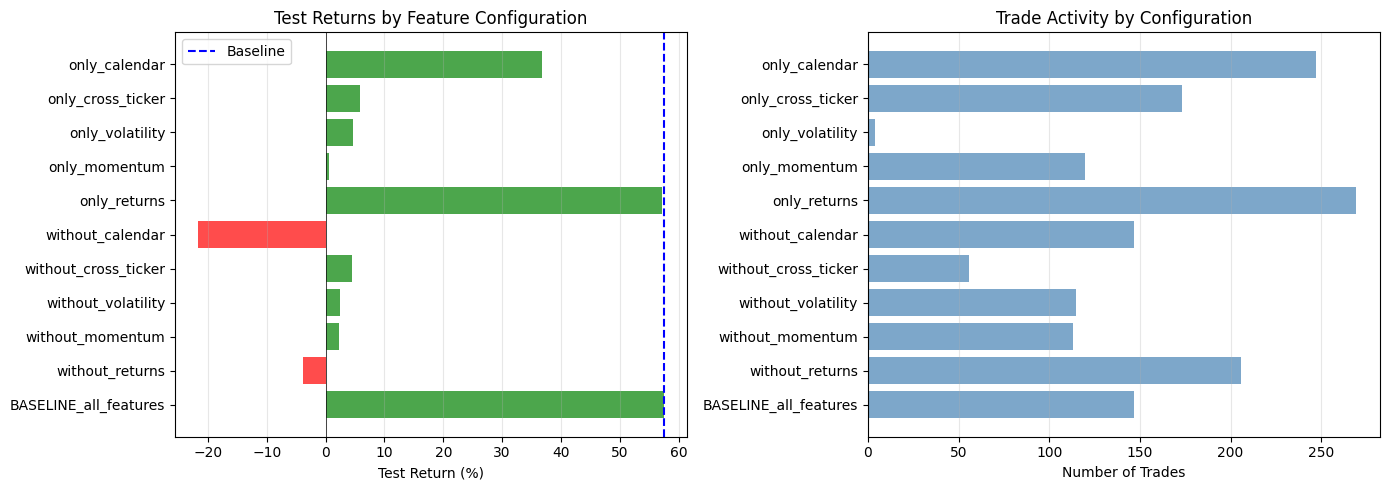

,experiment,n_features,features,test_return,n_trades,timesteps
0,BASELINE_all_features,27,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",57.485664,147,50000
1,without_returns,25,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",-3.839296,206,50000
2,without_momentum,19,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",2.216339,113,50000
3,without_volatility,25,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",2.429044,115,50000
4,without_cross_ticker,15,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",4.421389,56,50000
5,without_calendar,23,"[PPH_Open, PPH_High, PPH_Low, PPH_Close, PPH_V...",-21.617842,147,50000
6,only_returns,2,"[PPH_Return_1d, XPH_Return_1d]",57.090462,269,50000
7,only_momentum,8,"[PPH_SMA_10, PPH_RSI_14, PPH_StochK, PPH_Stoch...",0.581920,120,50000
8,only_volatility,2,"[PPH_Entropy_20, XPH_Entropy_20]",4.601419,4,50000
9,only_cross_ticker,12,"[XPH_Open, XPH_High, XPH_Low, XPH_Close, XPH_V...",5.795097,173,50000


In [15]:
# Uncomment to run (takes 10-30 min)
ablation_results = feature_selector.ablation_study(timesteps=50000)
feature_selector.plot_results()

## 15. Hyperparameter Search

Random search over reward shaping and PPO hyperparameters.

Searches over:
- `reward_scaling`: [10, 50, 100, 200]
- `trade_penalty`: [0, 0.0005, 0.001, 0.002]
- `profit_bonus`: [0, 0.25, 0.5, 1.0]
- `ent_coef`: [0.01, 0.05, 0.1]
- `gamma`: [0.9, 0.95, 0.99]

In [ ]:
# ============================================
# HYPERPARAMETER GRID SEARCH
# ============================================
# Test different reward shaping configurations

def hyperparameter_search(feature_subset=None, n_trials=10, timesteps=50000):
    """
    Random search over reward shaping hyperparameters.
    """
    if feature_subset is None:
        feature_subset = feature_cols.tolist()

    signal_features_search = df[feature_subset].values.astype(np.float32)

    # Hyperparameter search space
    param_space = {
        'reward_scaling': [10, 50, 100, 200],
        'trade_penalty': [0.0, 0.0005, 0.001, 0.002],
        'profit_bonus': [0.0, 0.25, 0.5, 1.0],
        'trend_following_bonus': [0.0, 0.0001, 0.0005],
        'ent_coef': [0.01, 0.05, 0.1],
        'gamma': [0.9, 0.95, 0.99],
    }

    results = []

    print("="*60)
    print(f"HYPERPARAMETER SEARCH ({n_trials} trials)")
    print("="*60)

    for trial in range(n_trials):
        # Random sample from parameter space
        params = {k: np.random.choice(v) for k, v in param_space.items()}

        reward_config = {
            'fee': 0.0005,
            'holding_cost': 0.0,
            'short_borrow_cost': 0.0,
            'reward_scaling': params['reward_scaling'],
            'trade_penalty': params['trade_penalty'],
            'profit_bonus': params['profit_bonus'],
            'trend_following_bonus': params['trend_following_bonus'],
        }

        # Create environment
        def make_env(bounds):
            def _init():
                return FlexibleTradingEnv(
                    df=df,
                    prices=prices,
                    signal_features=signal_features_search,
                    window_size=window_size,
                    frame_bound=bounds,
                    include_position_in_obs=True,
                    **reward_config
                )
            return _init

        train_env = DummyVecEnv([make_env(train_frame_bound)])
        train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

        # Train model
        model = PPO(
            "MlpPolicy",
            train_env,
            learning_rate=3e-4,
            n_steps=1024,
            batch_size=64,
            gamma=params['gamma'],
            ent_coef=params['ent_coef'],
            verbose=0,
            seed=trial
        )

        model.learn(total_timesteps=timesteps)

        # Evaluate
        test_env = DummyVecEnv([make_env(test_frame_bound)])
        test_env = VecNormalize(test_env, training=False, norm_obs=True, norm_reward=False)
        test_env.obs_rms = train_env.obs_rms

        obs = test_env.reset()
        done = False
        equity = 1.0
        n_trades = 0
        last_pos = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, info = test_env.step(action)
            done = bool(done[0])

            tick = info[0]["tick"]
            pos = info[0]["position"]

            if pos != last_pos:
                n_trades += 1

            price_ratio = prices[tick] / prices[tick - 1]
            equity *= price_ratio ** last_pos
            last_pos = pos

        test_return = (equity - 1) * 100

        results.append({
            'trial': trial,
            'test_return': test_return,
            'n_trades': n_trades,
            **params
        })

        print(f"Trial {trial+1}/{n_trials}: Return={test_return:+.2f}%, Trades={n_trades}")
        print(f"  Params: scaling={params['reward_scaling']}, penalty={params['trade_penalty']}, "
              f"bonus={params['profit_bonus']}, gamma={params['gamma']}, ent={params['ent_coef']}")

    # Find best
    results_df = pd.DataFrame(results)
    best_idx = results_df['test_return'].idxmax()
    best = results_df.loc[best_idx]

    print("\n" + "="*60)
    print("BEST CONFIGURATION:")
    print("="*60)
    print(f"  Test Return: {best['test_return']:+.2f}%")
    print(f"  Trades: {best['n_trades']}")
    print(f"  Parameters:")
    for k in param_space.keys():
        print(f"    {k}: {best[k]}")

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, param in enumerate(['reward_scaling', 'trade_penalty', 'profit_bonus', 'gamma', 'ent_coef']):
        ax = axes[i]
        ax.scatter(results_df[param], results_df['test_return'], alpha=0.6)
        ax.set_xlabel(param)
        ax.set_ylabel('Test Return (%)')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax.grid(alpha=0.3)

    axes[-1].hist(results_df['test_return'], bins=15, color='steelblue', alpha=0.7)
    axes[-1].set_xlabel('Test Return (%)')
    axes[-1].set_ylabel('Frequency')
    axes[-1].set_title('Return Distribution')

    plt.suptitle('Hyperparameter Search Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return results_df, best

# Run hyperparameter search (uncomment to run)
# hp_results, best_params = hyperparameter_search(n_trials=20, timesteps=50000)

: 

---

## 16. Troubleshooting Guide

| Symptom | Likely Cause | Solution |
|---------|--------------|----------|
| Always same position | Reward too sparse | Increase `reward_scaling` |
| Too many trades | No trade penalty | Increase `trade_penalty` |
| Overfits train | Too complex features | Remove weak feature groups |
| Random behavior | Features not predictive | Check diagnostic cell |
| Worse than B&H | Bad market regime | Try different date ranges |

**Next steps if still failing:**
- Try A2C or SAC algorithms
- Add LSTM policy for temporal patterns
- Increase data (more tickers, longer history)